In [1]:
from analysis import Bittrex

Loading BokehJS ...

In [2]:
# instance olusturuyoruz
analysis = Bittrex()

# kullanılabilecek metodlar: 
#     .get_summary('eth')
#     .tick('eth')
#     .get_market()
#     .get_orderbook('eth')
#     .orderbook_analysis('eth', sample=10)
#     .plot('eth', loop=0, sleep=5)

In [ ]:
# ilgili coin icin request anindaki son degerleri getirir
analysis.get_summary('eth')

In [ ]:
# coin icin son - alis/satis talimatinin deger bilgilerini getirir
# not : get_summary metodundaki verilerle aynidir
analysis.tick('eth')

In [ ]:
# Bittrex uzerindeki tum coinlerin market bilgilerini getirir
analysis.get_market()

In [ ]:
# verilen coin icin o an acik olan tum alis/satis talimalarini gosterir. 
# Quantity: coinden kac adet oldugu, Rate: BTC cinsinden talimat degeri
analysis.get_orderbook('eth')

In [ ]:
# orderbook uzerinden bir deger analizi cikarilir. sample sayisi kadar son orderlar, 
# bunlarin toplami ve sample sayisi kadar orderin grafik egri degeri hesaplanir
analysis.orderbook_analysis('eth', sample=10)

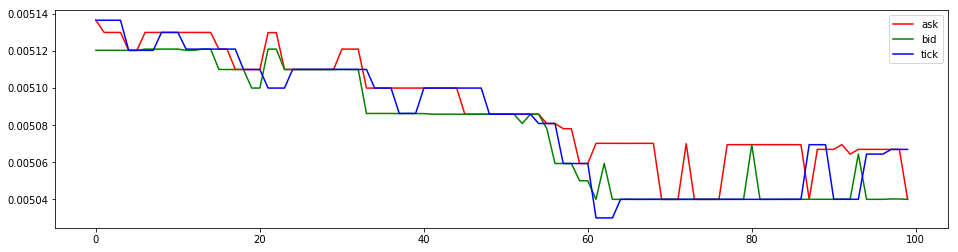

In [4]:
# coin icin anlik alis-satis talimatlari ve deger bilgileri grafigi yazdirilir. 
# loop = 0 : surekli ekrana basar, 
# loop = N : N saniye kadar calisir
# sleep = N : her bir request icin N saniye kadar bekler
analysis.plot('neo', loop=100, sleep=3)

In [3]:
# yazdirilan verilerin grafigini cikarir
analysis.plot_file('neo', path='data/')

In [7]:
#!/usr/bin/env python3.6

import requests, json, time, hmac, hashlib
from matplotlib import pyplot as plt
import multiprocessing
import os
from pandas import read_csv
plt.rcParams['figure.figsize'] = (16,4)
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from sklearn.preprocessing import MinMaxScaler
output_notebook()

class Bittrex(object):
    def __init__(self, auth_info=None):
        self.key    = auth_info and auth_info['key']
        self.secret = auth_info and auth_info['secret']
        self.uri    = 'https://bittrex.com/api/v1.1'

    def get_request(self, url, sign):
        return requests.get(url, headers={'apisign': sign}).json()
    
    def infinity(self): 
        while True: 
            yield
    
    def scale(self, data, minX, maxX):
        scaler = MinMaxScaler(feature_range=(minX, maxX), copy=False)
        scaler.fit(data.reshape(-1, 1))
        return scaler.transform(data.reshape(-1, 1)).reshape(-1)
    
    def dispatch(self, output, result_only=True, index=None):
        if index:
            return output.json()['result'][index] if result_only else output.json()
        else:
            return output.json()['result'] if result_only else output.json()
        
    
    def get_balance(self, all=False, result_only=True):
        url    = self.uri + '/account/getbalances?apikey={}&nonce={}'.format(self.key, time.time())
        sign   = hmac.new(self.secret.encode(), url.encode(), hashlib.sha512).hexdigest()
        result = self.get_request(url, sign)
        
        if result_only:
            return result['result'] if all else list(filter(lambda x: x['Balance'] > 0, result['result']))
        else:
            return result if all else {'message': result['message'], 
                                   'success': result['success'], 
                                   'result': list(filter(lambda x: x['Balance'] > 0, result['result']))}
    
    def get_summary(self, c='vrm', base='btc', result_only=True):
        return self.dispatch(
            requests.get(self.uri + '/public/getmarketsummary?market={}-{}'.format(base, c)), 
            result_only=result_only, index=0)
        
    
    def tick(self, c='vrm', base='btc', result_only=True):
        return self.dispatch(
            requests.get(self.uri + '/public/getticker?market={}-{}'.format(base, c)),
            result_only=result_only)

    def get_coins(self, base='BTC'):
        return list(map(lambda x: x['MarketCurrency'], filter(lambda y: 
                           y['BaseCurrency'] == base.upper(), 
                           requests.get(self.uri + '/public/getmarkets/').json()['result'])))
    
    
    def get_market(self, result_only=True):
        return self.dispatch(
            requests.get(self.uri + '/public/getmarkets/'),
            result_only)
    
    def get_orderbook(self, c='vrm', base='btc', result_only=True):
        return self.dispatch(
            requests.get(self.uri + '/public/getorderbook?market={}-{}&type=both'.format(base, c)),
            result_only)
    
    def orderbook_analysis(self, c='vrm', base='btc', sample=10):
        def get_score(arr):
            total_diff = 0
            for i in range(len(arr)-1):
                slope = abs(1/(arr[i+1] - arr[i]))
                total_diff += slope
            return total_diff
        
        orderbook = self.get_orderbook(c=c, base=base, result_only=True)
        
        total_buy_orders = 0
        buy_order_list   = []
        for buy_order in orderbook['buy'][:sample]: # {'Quantity/Size(ETH)': 2.26034925, 'Rate/Bid(BTC)': 0.04627} 
            quantity           = buy_order['Quantity']
            bid                = buy_order['Rate']
            buy_order_in_btc   = quantity * bid
            total_buy_orders   += buy_order_in_btc
            buy_order_list.append(total_buy_orders)
        
        total_sell_orders = 0
        sell_order_list   = []
        for buy_order in orderbook['sell'][:sample]: # {'Quantity/Size(ETH)': 2.26034925, 'Rate/Ask(BTC)': 0.04627} 
            quantity           = buy_order['Quantity']
            ask                = buy_order['Rate']
            sell_order_in_btc  = quantity * ask
            total_sell_orders  += sell_order_in_btc
            sell_order_list.append(total_sell_orders)
        
        return {'total_buy_orders': total_buy_orders,
                'total_sell_orders': total_sell_orders,
                'buy_orders': buy_order_list,
                'sell_orders': sell_order_list,
                'buy_order_slope': get_score(buy_order_list),
                'sell_order_slope': get_score(sell_order_list)}
    
    # all = True for all coins, all = ['ETH', 'VRM', ..] for specific coins
    # loop = 0 for a infinite loop, loop = 5 for 5 loops
    # sleep = 60 for a 60 second sleep time between two requests
    def write_serial(self, all=True, loop=0, sleep=60, folder=''):
        while True:
            try:
                coinlist = self.get_coins() if all == True else all
                loop = self.infinity() if loop == 0 else range(loop)

                for coin in coinlist:
                    coin     = coin.upper()
                    filepath = '{}{}_analysis.csv'.format(folder, coin)

                    if not os.path.isfile(filepath):

                        f = open(filepath, 'w')
                        f.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(
                            "timestamp", "tick", "ask", "bid", "vol", "buys", 
                            "sells", "btc_tick", "btc_buys", "btc_sells", "btc_vol", "usdt",
                            "first_page_buy_orders", "first_page_sell_orders"))

                    for i in loop:
                        f = open(filepath, 'a')

                        coin_summary = self.get_summary(coin)[0]
                        timestamp    = coin_summary['TimeStamp']
                        tick         = coin_summary['Last']
                        ask          = coin_summary['Ask']
                        bid          = coin_summary['Bid']
                        vol          = coin_summary['BaseVolume']
                        buys         = coin_summary['OpenBuyOrders']
                        sells        = coin_summary['OpenSellOrders']

                        btc_market   = self.get_summary('btc', base='usdt')[0]
                        btc_tick     = btc_market['Last']
                        btc_buys     = btc_market['OpenBuyOrders']
                        btc_sells    = btc_market['OpenSellOrders']
                        btc_vol      = btc_market['Volume']

                        usdt         = tick * btc_tick
                        
                        try:
                            order_book   = self.orderbook_analysis(coin)
                            first_page_buy_orders = order_book['total_buy_orders']
                            first_page_sell_orders = order_book['total_sell_orders']
                        except:
                            first_page_buy_orders = 0
                            first_page_sell_orders = 0
                        

                        f.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(
                            timestamp, tick, ask, bid, vol, buys, 
                            sells, btc_tick, btc_buys, btc_sells, btc_vol, 
                            usdt, first_page_buy_orders, first_page_sell_orders))

                        f.close()
                        time.sleep(sleep)
            except Exception as e:
                print(e)
                time.sleep(30)
    
    def write(self, all=True, loop=0, sleep=60, folder=''):
        coinlist = self.get_coins() if all == True else all        
        
        jobs = []
        for coin in coinlist:
            thread = multiprocessing.Process(target=self.write_serial, args=([coin], loop, sleep, folder))
            jobs.append(thread)
        
        for j in jobs:
            try:
                j.start()
            except:
                j.start()
            
        for j in jobs:
            j.join()

        
        
    def plot(self, c='vrm', base='btc', loop=0, sleep=10):
        try:
            from IPython.display import clear_output
            plt.rcParams['figure.figsize'] = (16,4)
        except:
            raise("This method only works on IPython notebook!")
            
        coin         = c.upper()
        loop         = self.infinity() if loop == 0 else range(loop)
        
        tick, ask, bid = [], [], []
        for i in loop:
            clear_output(wait=True)
            coin_summary = self.get_summary(coin, base=base)[0]
            
            tick.append(coin_summary['Last'])
            ask.append(coin_summary['Ask'])
            bid.append(coin_summary['Bid'])
            
            plt.plot(ask, color='r', label='ask')
            plt.plot(bid, color='g', label='bid')
            plt.plot(tick, color='b', label='tick')
            plt.legend()
            plt.show()
            time.sleep(sleep)
            
    def plot_file(self, c='vrm', path='cryptoAnalysis/', output_file=False):
        if output_file:
            output_file("prediction.html", title="prediction")
        data = read_csv('{}{}_analysis.csv'.format(path,c.upper()), header=0, index_col=0)
        headers       = [i for i in data.axes[1]]
        data = data.values
        

        x = [i for i in range(data.shape[0])]
        
        

        plottick = figure(title='tick analysis', x_axis_label='time (1min per dot)', y_axis_label='value', 
                        width=950, height=300, sizing_mode='scale_width', 
                        tools = "xwheel_zoom,undo,redo,xpan,save,reset,hover,box_zoom",active_scroll="xwheel_zoom")
    
        x_tick = data[:,0].copy()
        x_ask  = data[:,1]
        x_sell = data[:,2]

        plottick.line(x, x_tick, legend='tick', line_width=2, line_color='blue', alpha=0.8)
        plottick.line(x, x_ask, legend='ask', line_width=1, line_color='red', alpha=0.8)
        plottick.line(x, x_sell, legend='bid', line_width=1, line_color='green', alpha=0.8)

        
        plotvol = figure(title='volume analysis', x_axis_label='time (1min per dot)', y_axis_label='value', 
                        width=950, height=300, sizing_mode='scale_width', 
                        tools = "xwheel_zoom,undo,redo,xpan,save,reset,hover,box_zoom",active_scroll="xwheel_zoom")

        minvol = data[:,4].min() if data[:,4].min() < data[:,5].min() else data[:,5].min()
        maxvol = data[:,4].max() if data[:,4].max() > data[:,5].max() else data[:,5].max()
    
    
        vol_tick = data[:,0].copy()
        vol_tick = self.scale(vol_tick, minvol, maxvol)
        
        plotvol.line(x, vol_tick, legend='tick', line_width=2, line_color='blue', alpha=0.8)
        plotvol.line(x, data[:,4], legend='buys', line_width=1, line_color='green', alpha=0.8)
        plotvol.line(x, data[:,5], legend='sells', line_width=1, line_color='red', alpha=0.8)
        
        plot1stpage = figure(title='1st page analysis', x_axis_label='time (1min per dot)', y_axis_label='value', 
                        width=950, height=300, sizing_mode='scale_width', 
                        tools = "xwheel_zoom,undo,redo,xpan,save,reset,hover,box_zoom",active_scroll="xwheel_zoom")
        
        minvol1stpage = data[:,11].min() if data[:,11].min() < data[:,12].min() else data[:,12].min()
        maxvol1stpage = data[:,11].max() if data[:,11].max() > data[:,12].max() else data[:,12].max()
        
        
        stpage_tick = data[:,0].copy()
        stpage_tick = self.scale(stpage_tick, minvol1stpage, maxvol1stpage)
        
        plot1stpage.line(x, stpage_tick, legend='tick', line_width=2, line_color='blue', alpha=0.8)
        plot1stpage.line(x, data[:,11], legend='1st page buys', line_width=1, line_color='green', alpha=0.8)
        plot1stpage.line(x, data[:,12], legend='1st page sells', line_width=1, line_color='red', alpha=0.8)
        
        
        
        
        grid = gridplot([[plottick], [plotvol], [plot1stpage]])
        show(grid)
        
        
#crypto = Bittrex()
#crypto.write(all=True, loop=0, sleep=60, folder='data/') # will write to a data folder!! opens ~200 threads!!!


Loading BokehJS ...

In [18]:
a = Bittrex()

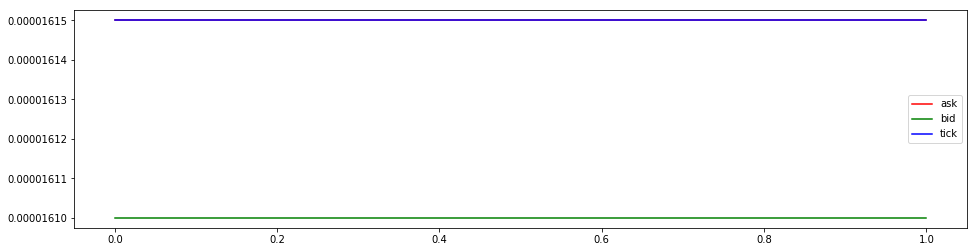

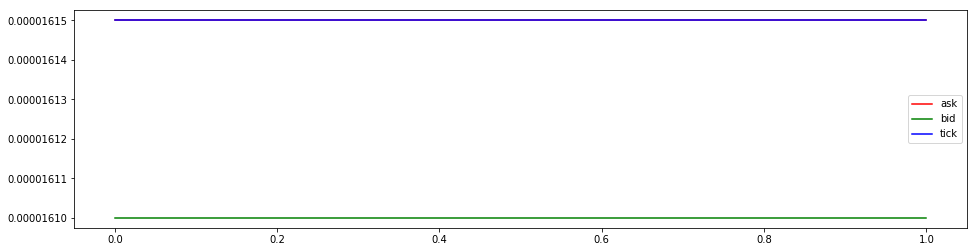

KeyboardInterrupt: 

In [20]:
a.plot('sngls')

In [17]:
import time
import numpy as np
from bokeh.models.sources import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
output_notebook()

my_figure = figure(plot_width=800, plot_height=400)
test_data = ColumnDataSource(data=dict(x=[0], y=[0]))
line = my_figure.line("x", "y", source=test_data)
handle = show(my_figure, notebook_handle=True)

new_data=dict(x=[0], y=[0])
x = []
y = []

step = 0
step_size = 0.1  # increment for increasing step
max_step = 100  # arbitrary stop point for example
period = .1  # in seconds (simulate waiting for new data)
n_show = 10  # number of points to keep and show
while step < max_step:
    x.append(step)
    y.append(np.random.rand())
    new_data['x'] = x = x[-n_show:]  # prevent filling ram
    new_data['y'] = y = y[-n_show:]  # prevent filling ram

    test_data.stream(new_data, n_show)

    push_notebook(handle=handle)
    step += step_size
    time.sleep(period)

Loading BokehJS ...